In [1]:
from pathlib import Path
import os

project_directory = Path(os.getcwd())

# Data loading and exploration

In [2]:
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

def get_mnist_loaders(batch_size : int = 16, data_path : Path = None):
    """
    Function to download MNIST dataset and return train- and test-loaders.
    :param batch_size:
    :param data_path: 
    """

    transform = transforms.Compose([
        transforms.ToTensor(),
    ])

    train_dataset = MNIST(root=data_path, train=True, download=True, transform=transform)
    test_dataset = MNIST(root=data_path, train=False, download=True, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

In [3]:
data_path = project_directory / "data"

batch_size = 16
train_loader, test_loader = get_mnist_loaders(batch_size, data_path)

print(f"{len(train_loader) * batch_size} train samples")
print(f"{len(test_loader) * batch_size} test samples")

60000 train samples
10000 test samples


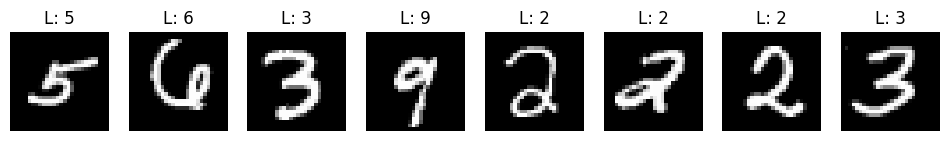

In [4]:
import matplotlib.pyplot as plt

# Display images from the first batch of the test loader
train_iterator = iter(train_loader)
batch = next(train_iterator)

def display_n_images(batch, num_to_display : int = 8):
    images, labels = batch
    fig, axes = plt.subplots(1, num_to_display, figsize=(12, 4))
    for i in range(num_to_display):
        image = transforms.ToPILImage()(images[i])  # Convert tensor to PIL Image
        axes[i].imshow(image, cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(f"L: {labels[i].item()}")
    plt.show()

display_n_images(batch, 8)

# Model and training loop

In [5]:
from torch import nn

class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()

        self.l1 = nn.Sequential(
            nn.Conv2d(1, 16, 5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )

        self.l2 = nn.Sequential(
            nn.Conv2d(16, 32, 3, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )

        self.l3 = nn.Sequential(
            nn.Conv2d(32, 64, 3, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )

        self.fc1 = nn.Linear(64*5*5, 10)
    
    def forward(self, x):
        x = self.l1(x)
        x = self.l2(x)
        x = self.l3(x)
        x = x.view(-1, 64*5*5)
        return self.fc1(x)
    
c = Classifier()

In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(c.parameters(), lr=0.001, momentum=0.9)

In [7]:
import torch

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Move the model to CUDA
c.to(device)

Device: cuda


Classifier(
  (l1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (l2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (l3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=1600, out_features=10, bias=True)
)

In [8]:
def train(train_set, epochs : int = 1, device : torch.device = "cpu", print_freq : int = 1000):
    """
    Train loop
    :param train_set: train dataloader
    :param epochs: number of epochs
    """

    loss_values = []

    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(train_set):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = c(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % print_freq == print_freq - 1:
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / print_freq:.3f}')
                running_loss = 0.0

        # Save loss for plotting
        loss_values.append(running_loss / len(train_set))

        model_path = project_directory / f'weights/epoch_{epoch+1}.pth'
        torch.save(c.state_dict(), model_path)
        print(f'Model saved at epoch {epoch+1}.')

    torch.save(c.state_dict(), project_directory / f'weights/final.pth')

    # Plot the loss
    plt.plot(range(1, epochs + 1), loss_values, marker='o')
    plt.title('Training Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.xticks(range(1, epochs + 1))  # Set x-axis ticks to integers only
    plt.ylabel('Loss')
    plt.ylim(bottom=0)
    plt.show()

    print('Finished Training')

In [9]:
# train(train_loader, 3, device)

# Model Evaluation

In [10]:
c = Classifier()
c.load_state_dict(torch.load(project_directory / f'weights/final.pth'))
c.eval()

Classifier(
  (l1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (l2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (l3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=1600, out_features=10, bias=True)
)

In [11]:
def get_accuracy(test_loader, model):
    """
    Get the accuracy of model on test dataset
    """

    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            # calculate outputs by running images through the network
            outputs = model(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f} %')

get_accuracy(test_loader, c)

Accuracy of the network on the 10000 test images: 98.28 %


In [12]:
from typing import List

def get_predictions(model: nn.Module, dataloader: DataLoader) -> List[int]:
    """
    Get predictions from a model for a given dataloader.
    :return all_predictions: List of predicted labels for the input data.
    """

    all_predictions = []

    with torch.no_grad():
        for images, _ in dataloader:
            # Forward pass
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            # Convert predictions to CPU and numpy for further analysis if needed
            all_predictions.extend(predicted.cpu().numpy())

    return all_predictions

# Get predictions for the test dataset
test_predictions = get_predictions(c, test_loader)


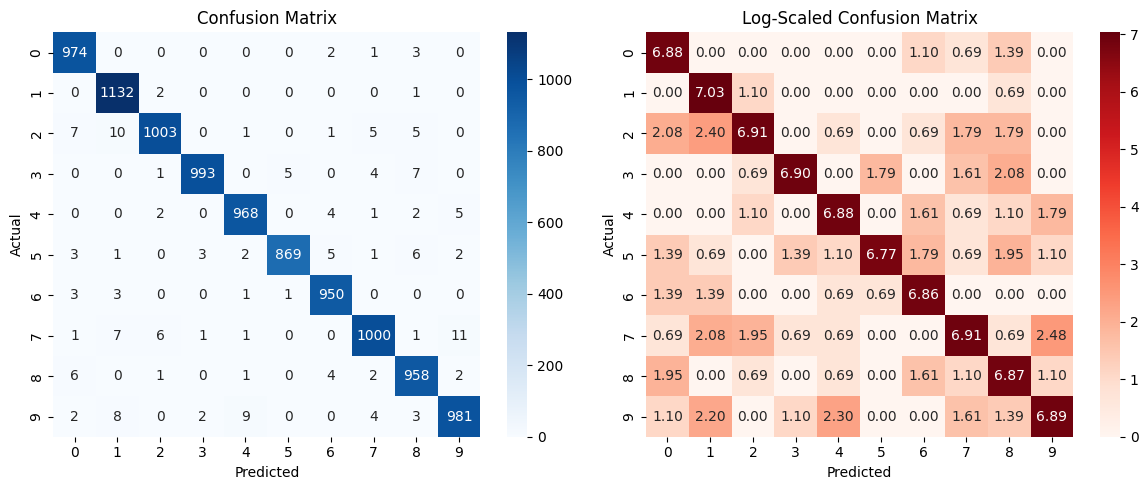

In [13]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from typing import List, Optional

def plot_confusion_matrices(actual_labels: List[int], predictions: List[int],
                             display_log_scaled: Optional[bool] = False) -> None:
    """
    Plot original and log-scaled confusion matrices side by side.

    :param actual_labels: ground truth labels for test dataset
    :param predictions: predicted labels for test dataste 
    :param display_log_scaled: flag to also display log-scaled confusion matrix (default is false)
    """

    cm = confusion_matrix(actual_labels, predictions)

    plt.figure(figsize=(12, 5))

    # Plot the original confusion matrix
    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f'Confusion Matrix')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

    # Plot the log-scaled confusion matrix if required
    if display_log_scaled:
        plt.subplot(1, 2, 2)
        sns.heatmap(np.log1p(cm), annot=True, fmt=".2f", cmap="Reds")
        plt.title(f'Log-Scaled Confusion Matrix')
        plt.xlabel("Predicted")
        plt.ylabel("Actual")

    plt.tight_layout()
    plt.show()

actual_labels = [label for _, label in test_loader.dataset]
test_predictions = get_predictions(c, test_loader)
plot_confusion_matrices(actual_labels, test_predictions, display_log_scaled=True)

## FGSM

In [147]:
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon * sign_data_grad
    
    # Clip the perturbed image values to ensure they stay within the valid range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    
    return perturbed_image

In [148]:
model = Classifier()
model.load_state_dict(torch.load(project_directory / f'weights/final.pth'))
model.eval()

Classifier(
  (l1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (l2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (l3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=1600, out_features=10, bias=True)
)

In [149]:
batch = next(iter(train_loader))
data, target = batch
data.requires_grad = True
data.retain_grad = True

In [150]:
output = model(batch[0])
predicted_label = torch.argmax(output, 1)

print(predicted_label)
print(target)

loss = torch.nn.CrossEntropyLoss()(output, target)

tensor([1, 2, 9, 8, 4, 4, 1, 0, 9, 3, 1, 3, 7, 1, 7, 7])
tensor([1, 2, 9, 8, 4, 4, 1, 0, 9, 5, 4, 3, 9, 1, 7, 7])


In [151]:
model.zero_grad()
loss.backward()
data_grad = data.grad.data

In [156]:
epsilon = 0.5  # Adjust this value to control the strength of the attack
perturbed_image = fgsm_attack(data, epsilon, data_grad)

In [157]:
output = model(perturbed_image)
new_predicted_label = torch.argmax(output, 1)

In [158]:
image_np = np.transpose(data.squeeze().detach().numpy(), (1, 2, 0))
perturbed_image_np = np.transpose(perturbed_image.squeeze().detach().numpy(), (1, 2, 0))

print(image_np.shape)
original_images = np.einsum("rci -> irc", image_np)
perturbed_images = np.einsum("rci -> irc", perturbed_image_np)

(28, 28, 16)


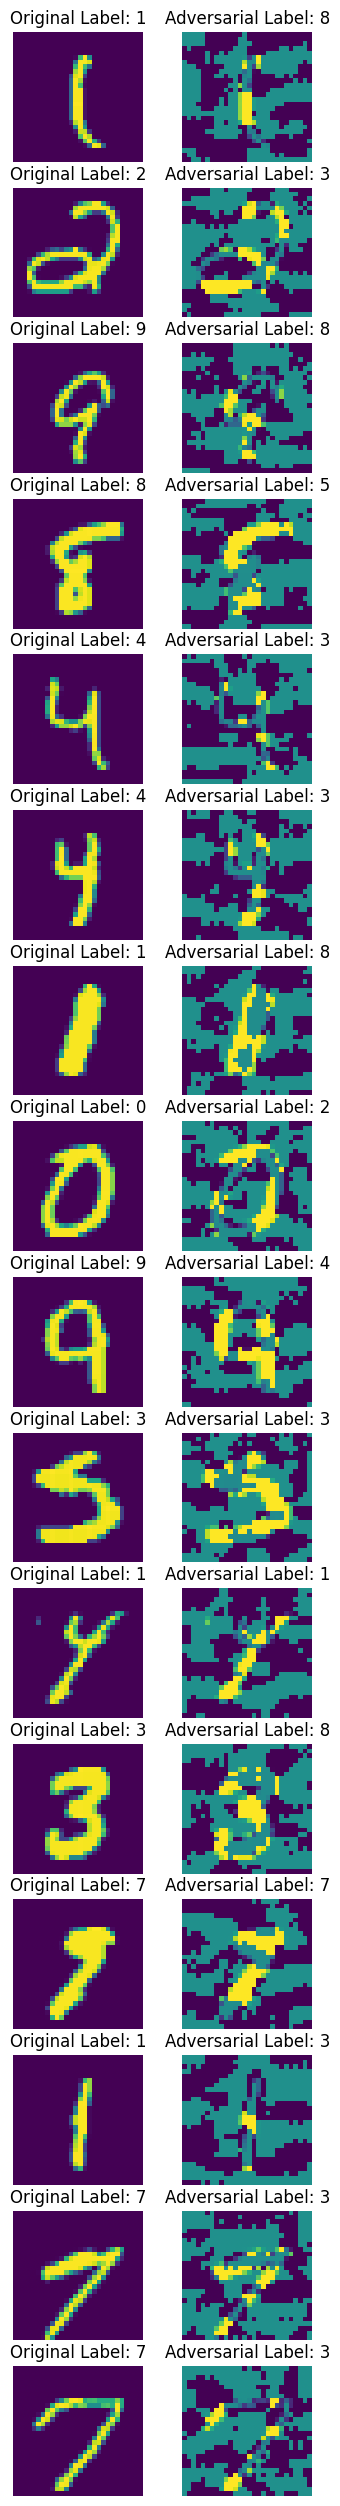

In [159]:
import matplotlib.pyplot as plt
import numpy as np

def show_image_label(ax, image, label):
    ax.imshow(image)
    ax.axis('off')
    ax.set_title(label)

fig, axs = plt.subplots(len(original_images), 2, figsize=(4, len(original_images) * 2))

for i, (orig, pert, orig_label, pert_label) in enumerate(zip(original_images, perturbed_images, predicted_label, new_predicted_label)):
    axs[i, 0].imshow(orig)
    axs[i, 0].axis('off')
    axs[i, 0].set_title(f'Original Label: {orig_label}')

    axs[i, 1].imshow(pert)
    axs[i, 1].axis('off')
    axs[i, 1].set_title(f'Adversarial Label: {pert_label}')

plt.show()
